## Introduction

This notebook will guide you through the basic steps to get started with Active Vision.

By the end of this notebook, you will be able to:

- Understand the basic workflow of active learning
- Understand the basic components of Active Vision
- Understand how to use Active Vision to train a model
- Understand how to use Active Vision to iteratively improve your dataset

Before we start, we need to prepare 3 sets of data:

- Initial samples: A dataset of labeled images to train an initial model. If you don't have any labeled data, you can label some images yourself.
- Unlabeled samples: A dataset of unlabeled images. We will continuously sample from this set using active learning strategies.
- Evaluation samples: A dataset of labeled images. We will use this set to evaluate the performance of the model. This is the test set, DO NOT use it for active learning. Split this out in the beginning.

We will use the Imagenette dataset as a working example in this notebook.


## Download the dataset

First, lets download the dataset and extract it.

In [1]:
# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
# !tar -xvzf imagenette2.tgz
# !mv imagenette2 data/imagenette
# !rm imagenette2.tgz

## Load the dataset

`active-vision` currently supports datasets in a pandas dataframe format. The dataframe should have at least 2 columns: `filepath` and `label`.

In [1]:
from fastai.vision.all import get_image_files

path = "data/imagenette/train"
image_files = get_image_files(path)
len(image_files)

9469

In [2]:
lbl_dict = {
    "n01440764": "tench",
    "n02102040": "English springer",
    "n02979186": "cassette player",
    "n03000684": "chain saw",
    "n03028079": "church",
    "n03394916": "French horn",
    "n03417042": "garbage truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute",
}


In [3]:
import pandas as pd

# Create a dataframe with the filepath and label from parent directory
labels = [str(path.parts[-2]) for path in image_files]

# Map the labels to the label dictionary
labels = [lbl_dict[lbl] for lbl in labels]

df = pd.DataFrame({"filepath": [str(path) for path in image_files], "label": labels})

df

,filepath,label
0,data/imagenette/train/n03394916/ILSVRC2012_val_00046669.JPEG,French horn
1,data/imagenette/train/n03394916/n03394916_58454.JPEG,French horn
2,data/imagenette/train/n03394916/n03394916_32588.JPEG,French horn
3,data/imagenette/train/n03394916/n03394916_33663.JPEG,French horn
4,data/imagenette/train/n03394916/n03394916_27948.JPEG,French horn
...,...,...
9464,data/imagenette/train/n02979186/n02979186_8089.JPEG,cassette player
9465,data/imagenette/train/n02979186/n02979186_19444.JPEG,cassette player
9466,data/imagenette/train/n02979186/n02979186_11074.JPEG,cassette player
9467,data/imagenette/train/n02979186/n02979186_2938.JPEG,cassette player


As an initial step, we will randomly sample 10 samples from each class.

In [4]:
initial_samples = (
    df.groupby("label")
    .apply(lambda x: x.sample(n=10, random_state=316))
    .reset_index(drop=True)
)

initial_samples

/var/folders/9y/5mpk58851fq38f8ljx2svvnm0000gn/T/ipykernel_99032/414664958.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10, random_state=316))


,filepath,label
0,data/imagenette/train/n02102040/n02102040_2788.JPEG,English springer
1,data/imagenette/train/n02102040/n02102040_3759.JPEG,English springer
2,data/imagenette/train/n02102040/n02102040_1916.JPEG,English springer
3,data/imagenette/train/n02102040/n02102040_6147.JPEG,English springer
4,data/imagenette/train/n02102040/n02102040_403.JPEG,English springer
...,...,...
95,data/imagenette/train/n01440764/n01440764_10043.JPEG,tench
96,data/imagenette/train/n01440764/n01440764_31535.JPEG,tench
97,data/imagenette/train/n01440764/n01440764_12848.JPEG,tench
98,data/imagenette/train/n01440764/n01440764_3997.JPEG,tench


Let's check the distribution of the labels.

In [5]:
initial_samples["label"].value_counts()

label
English springer    10
French horn         10
cassette player     10
chain saw           10
church              10
garbage truck       10
gas pump            10
golf ball           10
parachute           10
tench               10
Name: count, dtype: int64

And save it to a parquet file.

In [6]:
initial_samples.to_parquet("initial_samples.parquet")

In [7]:
# Get the remaining samples by using pd.Index.difference
remaining_samples = df[~df.index.isin(initial_samples.index)].reset_index(drop=True)
remaining_samples


,filepath,label
0,data/imagenette/train/n03394916/n03394916_4437.JPEG,French horn
1,data/imagenette/train/n03394916/n03394916_42413.JPEG,French horn
2,data/imagenette/train/n03394916/n03394916_38808.JPEG,French horn
3,data/imagenette/train/n03394916/n03394916_24128.JPEG,French horn
4,data/imagenette/train/n03394916/n03394916_11289.JPEG,French horn
...,...,...
9364,data/imagenette/train/n02979186/n02979186_8089.JPEG,cassette player
9365,data/imagenette/train/n02979186/n02979186_19444.JPEG,cassette player
9366,data/imagenette/train/n02979186/n02979186_11074.JPEG,cassette player
9367,data/imagenette/train/n02979186/n02979186_2938.JPEG,cassette player


In [8]:
remaining_samples.to_parquet("unlabeled_samples.parquet")

Now let's create the evaluation samples which will be used to evaluate the performance of the model. We will use the validation set from the Imagenette dataset as the evaluation set.



In [9]:
path = "data/imagenette/val"
image_files = get_image_files(path)
len(image_files)


3925

In [10]:
labels = [str(path.parts[-2]) for path in image_files]

# Map the labels to the label dictionary
labels = [lbl_dict[lbl] for lbl in labels]

evaluation_samples = pd.DataFrame(
    {"filepath": [str(path) for path in image_files], "label": labels}
)

evaluation_samples

,filepath,label
0,data/imagenette/val/n03394916/n03394916_32422.JPEG,French horn
1,data/imagenette/val/n03394916/n03394916_69132.JPEG,French horn
2,data/imagenette/val/n03394916/n03394916_33771.JPEG,French horn
3,data/imagenette/val/n03394916/n03394916_29940.JPEG,French horn
4,data/imagenette/val/n03394916/ILSVRC2012_val_00033682.JPEG,French horn
...,...,...
3920,data/imagenette/val/n02979186/n02979186_27392.JPEG,cassette player
3921,data/imagenette/val/n02979186/n02979186_2742.JPEG,cassette player
3922,data/imagenette/val/n02979186/n02979186_2312.JPEG,cassette player
3923,data/imagenette/val/n02979186/n02979186_12822.JPEG,cassette player


In [11]:
evaluation_samples.to_parquet("evaluation_samples.parquet")

## Create an ActiveLearner

Now that we have an initial dataset, we can load it into an `ActiveLearner` object with a model.

Any fastai and timm models are supported. For simplicity, we will use a `resnet18` model.

In [12]:
from active_vision import ActiveLearner

al = ActiveLearner(name="initial-cycle")
al.load_model(model="resnet18", pretrained=True, device="mps")

2025-01-28 00:28:43.869 | INFO     | active_vision.core:load_model:65 - Loading a pretrained timm model `resnet18` on `mps`


We can load the initial samples into the `ActiveLearner` object.

In [13]:
al.load_dataset(
    initial_samples, filepath_col="filepath", label_col="label", batch_size=8
)

2025-01-28 00:28:46.216 | INFO     | active_vision.core:load_dataset:113 - Loading dataset from `filepath` and `label` columns
2025-01-28 00:28:46.361 | INFO     | active_vision.core:load_dataset:138 - Creating new learner
2025-01-28 00:28:47.407 | INFO     | active_vision.core:_optimize_learner:92 - Enabled mixed precision training
2025-01-28 00:28:47.408 | INFO     | active_vision.core:_finalize_setup:100 - Done. Ready to train.


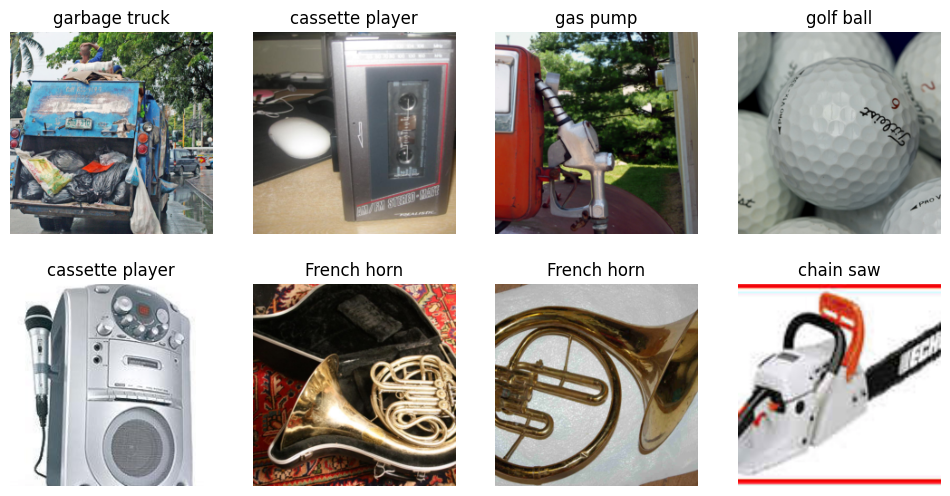

In [14]:
al.show_batch()

You can inspect the train and validation sets too.

In [15]:
al.train_set

,filepath,label
24,data/imagenette/train/n02979186/n02979186_16584.JPEG,cassette player
3,data/imagenette/train/n02102040/n02102040_6147.JPEG,English springer
72,data/imagenette/train/n03445777/n03445777_5916.JPEG,golf ball
4,data/imagenette/train/n02102040/n02102040_403.JPEG,English springer
20,data/imagenette/train/n02979186/n02979186_18377.JPEG,cassette player
...,...,...
62,data/imagenette/train/n03425413/n03425413_1759.JPEG,gas pump
65,data/imagenette/train/n03425413/n03425413_2074.JPEG,gas pump
63,data/imagenette/train/n03425413/n03425413_13576.JPEG,gas pump
32,data/imagenette/train/n03000684/n03000684_8985.JPEG,chain saw


In [16]:
al.valid_set

,filepath,label
84,data/imagenette/train/n03888257/n03888257_8338.JPEG,parachute
93,data/imagenette/train/n01440764/n01440764_1383.JPEG,tench
75,data/imagenette/train/n03445777/ILSVRC2012_val_00044936.JPEG,golf ball
80,data/imagenette/train/n03888257/n03888257_20654.JPEG,parachute
89,data/imagenette/train/n03888257/n03888257_4345.JPEG,parachute
11,data/imagenette/train/n03394916/n03394916_21289.JPEG,French horn
12,data/imagenette/train/n03394916/n03394916_53429.JPEG,French horn
74,data/imagenette/train/n03445777/n03445777_10583.JPEG,golf ball
66,data/imagenette/train/n03425413/n03425413_8248.JPEG,gas pump
55,data/imagenette/train/n03417042/ILSVRC2012_val_00019147.JPEG,garbage truck


## Train 

Now that we have the initial dataset, we can train the model.

But first, let's check the optimal learning rate for the model.

2025-01-28 00:28:49.882 | INFO     | active_vision.core:lr_find:174 - Finding optimal learning rate
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-01-28 00:29:00.376 | INFO     | active_vision.core:lr_find:176 - Optimal learning rate: 0.0020892962347716093


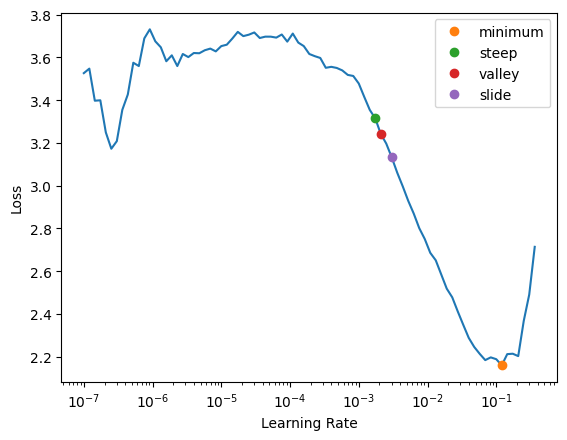

In [17]:
al.lr_find()

Not let's use the optimal learning rate to train the model end-to-end for 3 epochs and 1 epoch of head tuning.

2025-01-28 00:29:00.588 | INFO     | active_vision.core:train:187 - Training head for 1 epochs
2025-01-28 00:29:00.588 | INFO     | active_vision.core:train:188 - Training model end-to-end for 3 epochs
2025-01-28 00:29:00.588 | INFO     | active_vision.core:train:189 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,2.743840,0.491975,0.800000,00:01


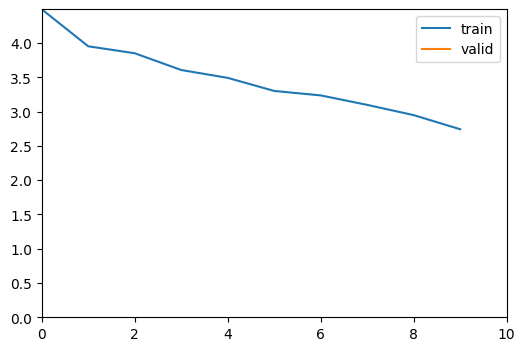

epoch,train_loss,valid_loss,accuracy,time
0,0.925639,0.139623,1.000000,00:02
1,0.672194,0.073631,1.000000,00:00
2,0.499570,0.075665,1.000000,00:00


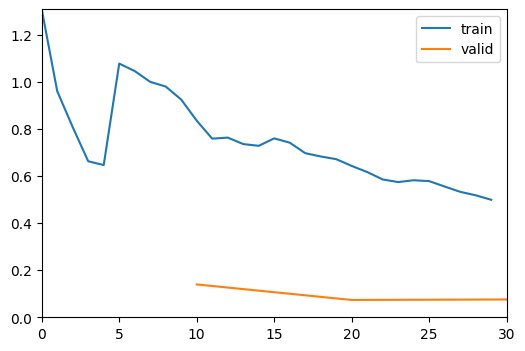

In [18]:
al.train(epochs=3, lr=5e-3, head_tuning_epochs=1)

## Evaluate

Now that we have a trained model, we can evaluate it on the evaluation set.

In [19]:
evaluation_df = pd.read_parquet("evaluation_samples.parquet")
evaluation_df

,filepath,label
0,data/imagenette/val/n03394916/n03394916_32422.JPEG,French horn
1,data/imagenette/val/n03394916/n03394916_69132.JPEG,French horn
2,data/imagenette/val/n03394916/n03394916_33771.JPEG,French horn
3,data/imagenette/val/n03394916/n03394916_29940.JPEG,French horn
4,data/imagenette/val/n03394916/ILSVRC2012_val_00033682.JPEG,French horn
...,...,...
3920,data/imagenette/val/n02979186/n02979186_27392.JPEG,cassette player
3921,data/imagenette/val/n02979186/n02979186_2742.JPEG,cassette player
3922,data/imagenette/val/n02979186/n02979186_2312.JPEG,cassette player
3923,data/imagenette/val/n02979186/n02979186_12822.JPEG,cassette player


In [20]:
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")

/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-01-28 00:29:23.660 | INFO     | active_vision.core:evaluate:255 - Accuracy: 88.89%


0.8889171974522293

That is a good start. ~88% accuracy is not bad for a first try with only 80 labeled samples. Let's see if we can improve it.

## Predict

Using the model, we can predict the labels of the unlabeled samples and get the most impactful samples to label.


In [21]:
df = pd.read_parquet("unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [22]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-28 00:29:29.556 | INFO     | active_vision.core:predict:198 - Running inference on 9369 samples
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


,filepath,pred_label,pred_conf,probs,logits,embeddings
0,data/imagenette/train/n03394916/n03394916_4437.JPEG,French horn,0.702575,"[0.007871299982070923, 0.7025746703147888, 0.15911456942558289, 0.04723506048321724, 0.009216577745974064, 0.0012782467529177666, 0.03501490131020546, 0.008387020789086819, 0.02827676385641098, 0.00103091262280941]","[-1.1798808574676514, 3.311647415161133, 1.8265202045440674, 0.6120321750640869, -1.0221003293991089, -2.997615098953247, 0.312669575214386, -1.1164188385009766, 0.09893620014190674, -3.2126595973968506]","[1.7773561477661133, 0.3583531379699707, -2.2600045204162598, -2.02286696434021, 0.9013167023658752, 1.5327991247177124, -1.9347699880599976, 0.24207410216331482, 1.2428958415985107, 0.37598755955696106, -0.5736100077629089, -2.057103157043457, 0.6456396579742432, -1.6576650142669678, -0.7645342350006104, -0.7559361457824707, 2.226775646209717, -2.6283340454101562, -6.025577068328857, -1.1683861017227173, 0.5599915385246277, -0.7826542258262634, 0.6365216970443726, 0.7310598492622375, -0.38535448908805847, 1.1020408868789673, -1.9870421886444092, 0.7199963331222534, -0.6163432598114014, -2..."
1,data/imagenette/train/n03394916/n03394916_42413.JPEG,French horn,0.996863,"[0.00023846143449191004, 0.9968634843826294, 2.2632639229414053e-05, 2.8792250304832123e-05, 0.0001072122176992707, 6.47406923235394e-05, 0.002336325356736779, 8.473212801618502e-05, 0.00018544317572377622, 6.816142558818683e-05]","[0.17705011367797852, 8.51521110534668, -2.177765130996704, -1.937051773071289, -0.6223481893539429, -1.126767873764038, 2.459176540374756, -0.8576629161834717, -0.07440988719463348, -1.0752789974212646]","[0.8158490061759949, -1.8339059352874756, -0.13018770515918732, -0.6049647331237793, 1.8616915941238403, -2.4069876670837402, -1.0639467239379883, -0.6052405834197998, 2.9080164432525635, 0.5989349484443665, 0.9044482707977295, -3.366297721862793, 1.970848560333252, -1.0846608877182007, -0.10765327513217926, 2.3892898559570312, 0.4114380180835724, 1.0473761558532715, 0.6070066690444946, 1.812180519104004, 1.60354745388031, 1.1100184917449951, -0.047067590057849884, 1.8844196796417236, -2.263213634490967, -0.31873366236686707, -1.521173357963562, -0.2627316415309906, 1.351643681526184, -0.3..."
2,data/imagenette/train/n03394916/n03394916_38808.JPEG,French horn,0.662511,"[0.013167515397071838, 0.6625107526779175, 0.0025839977897703648, 0.12695597112178802, 0.00722018675878644, 0.012060069479048252, 0.0133620360866189, 0.007349974475800991, 0.12358428537845612, 0.03120519034564495]","[-0.5301631689071655, 3.388120651245117, -2.158578395843506, 1.735924243927002, -1.1310354471206665, -0.6180161833763123, -0.5154986381530762, -1.1132190227508545, 1.7090072631835938, 0.33266833424568176]","[1.132337212562561, 0.29204505681991577, 0.3834224045276642, 1.2579203844070435, 1.4354114532470703, -1.740684986114502, 0.3960220217704773, -3.090731143951416, -0.11228737235069275, 0.08398108929395676, 0.9436655640602112, -3.3353631496429443, -0.8130388259887695, 0.4440263509750366, -0.6421388983726501, 1.018994927406311, -1.2717773914337158, -0.6749492287635803, -0.008008467964828014, 1.2434659004211426, 2.369237184524536, -1.2071843147277832, -0.3887590169906616, 0.089368537068367, 1.9249006509780884, -0.23882408440113068, 0.606177568435669, 0.0935852974653244, 0.044213276356458664, 0...."
3,data/imagenette/train/n03394916/n03394916_24128.JPEG,French horn,0.635238,"[0.0012827255995944142, 0.6352384686470032, 0.01504630595445633, 0.3226848840713501, 0.001584128476679325, 0.0025851470418274403, 0.004057606682181358, 0.0017511507030576468, 0.014491082169115543, 0.0012785402359440923]","[-1.4002482891082764, 4.804764747619629, 1.0618969202041626, 4.127440452575684, -1.1892015933990479, -0.6994532346725464, -0.24864226579666138, -1.088962435722351, 1.024297833442688, -1.4035166501998901]","[0.37831351161003113, -3.2015252113342285, -2.1200900077819824, 0.8438243865966797, -2.038696527481079, 1.602285623550415, 

## Sample

With the predicted labels, we can sample the most impactful samples to label using active learning strategies.

For this example, we will use the `sample_uncertain` strategy to sample the most uncertain samples. This will pull out samples that the model is most unsure about.


In [23]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=20)
uncertain_df

2025-01-28 00:30:09.358 | INFO     | active_vision.core:sample_uncertain:275 - Using least confidence strategy to get top 20 samples


,filepath,pred_label,pred_conf,score,probs,logits
7185,data/imagenette/train/n03000684/n03000684_15363.JPEG,parachute,0.1564,0.8436,"[0.07706766575574875, 0.010804376564919949, 0.0016676075756549835, 0.13243111968040466, 0.12117990851402283, 0.09609027951955795, 0.13799168169498444, 0.11230389773845673, 0.15635685622692108, 0.1541065275669098]","[-0.18387377262115479, -2.148606300354004, -4.017167568206787, 0.357505202293396, 0.2687187194824219, 0.03673066198825836, 0.3986358642578125, 0.19265097379684448, 0.5235834121704102, 0.5090866088867188]"
7581,data/imagenette/train/n01440764/n01440764_5535.JPEG,cassette player,0.1899,0.8101,"[0.0016243687132373452, 0.03174137324094772, 0.1899459809064865, 0.1477864682674408, 0.16400666534900665, 0.09513696283102036, 0.03560095280408859, 0.011093263514339924, 0.16707386076450348, 0.1559900939464569]","[-3.4048492908477783, -0.43234726786613464, 1.356771469116211, 1.1058002710342407, 1.209938883781433, 0.6653493046760559, -0.31759586930274963, -1.4836302995681763, 1.2284677028656006, 1.159824252128601]"
2702,data/imagenette/train/n03445777/n03445777_16413.JPEG,gas pump,0.1911,0.8089,"[0.08848834037780762, 0.026411836966872215, 0.12205954641103745, 0.12274359166622162, 0.09393336623907089, 0.07021037489175797, 0.19112302362918854, 0.056307487189769745, 0.14821428060531616, 0.08050814270973206]","[0.15328258275985718, -1.0557760000228882, 0.47492074966430664, 0.4805092513561249, 0.2129974067211151, -0.07809227705001831, 0.9233290553092957, -0.29876071214675903, 0.669070839881897, 0.05877009034156799]"
593,data/imagenette/train/n03394916/n03394916_47287.JPEG,parachute,0.1974,0.8026,"[0.045942578464746475, 0.1785338670015335, 0.04635618254542351, 0.18346253037452698, 0.005333770532160997, 0.1304447054862976, 0.06379850208759308, 0.1296463906764984, 0.1974310427904129, 0.01905045099556446]","[0.02168852835893631, 1.3790745735168457, 0.030651018023490906, 1.4063067436218262, -2.131645441055298, 1.0652457475662231, 0.3500259518623352, 1.0591069459915161, 1.479685664176941, -0.8586128354072571]"
8615,data/imagenette/train/n02979186/n02979186_6056.JPEG,garbage truck,0.1991,0.8009,"[0.11127179116010666, 0.11753886938095093, 0.1671621948480606, 0.08085840940475464, 0.08419448137283325, 0.199149489402771, 0.016224047169089317, 0.02551649883389473, 0.006324423011392355, 0.19175982475280762]","[0.6669437289237976, 0.7217370271682739, 1.0739325284957886, 0.3476675748825073, 0.38809734582901, 1.249023675918579, -1.2585374116897583, -0.8057066202163696, -2.200613260269165, 1.2112115621566772]"
1023,data/imagenette/train/n03417042/n03417042_12304.JPEG,chain saw,0.2075,0.7925,"[0.1316547393798828, 0.20296134054660797, 0.036395419389009476, 0.20750227570533752, 0.1253240704536438, 0.06169077008962631, 0.010642150416970253, 0.01546273659914732, 0.1264977604150772, 0.0818687453866005]","[0.6877816915512085, 1.1206142902374268, -0.5979583263397217, 1.142741084098816, 0.6385017037391663, -0.07026693224906921, -1.8275785446166992, -1.4539682865142822, 0.6478234529495239, 0.21271605789661407]"
8258,data/imagenette/train/n01440764/n01440764_22706.JPEG,English springer,0.2084,0.7916,"[0.2083987295627594, 0.14273466169834137, 0.01964343897998333, 0.06884118914604187, 0.1728888750076294, 0.012943624518811703, 0.004260709974914789, 0.05433467775583267, 0.18583519756793976, 0.1301189661026001]","[0.9521593451499939, 0.5736935138702393, -1.409550428390503, -0.1554916501045227, 0.7653551697731018, -1.826690435409546, -2.9378581047058105, -0.3921312689781189, 0.8375663161277771, 0.48115530610084534]"
2039,data/imagenette/train/n03445777/ILSVRC2012_val_00026194.JPEG,golf ball,0.2085,0.7915,"[0.06230958178639412, 0.070957250893116, 0.11526955664157867, 0.12024030834436417, 0.03788634017109871, 0.04759467765688896, 0.013631647452712059, 0.2084747701883316, 0.1956302523612976, 0.1280055195093155]","[-0.42145776748657227, -0.29149532318115234, 0.19370052218437195, 0.23591941595077515, -0.9189821481704712, -0.6908518075942993, 

## Label

Let's label the 20 most uncertain samples and save them to a parquet file named `uncertain.parquet`.

In [24]:
al.label(uncertain_df, output_filename="uncertain")

2025-01-28 00:30:20.430 | INFO     | active_vision.core:label:434 - Launching labeling interface for 20 samples


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


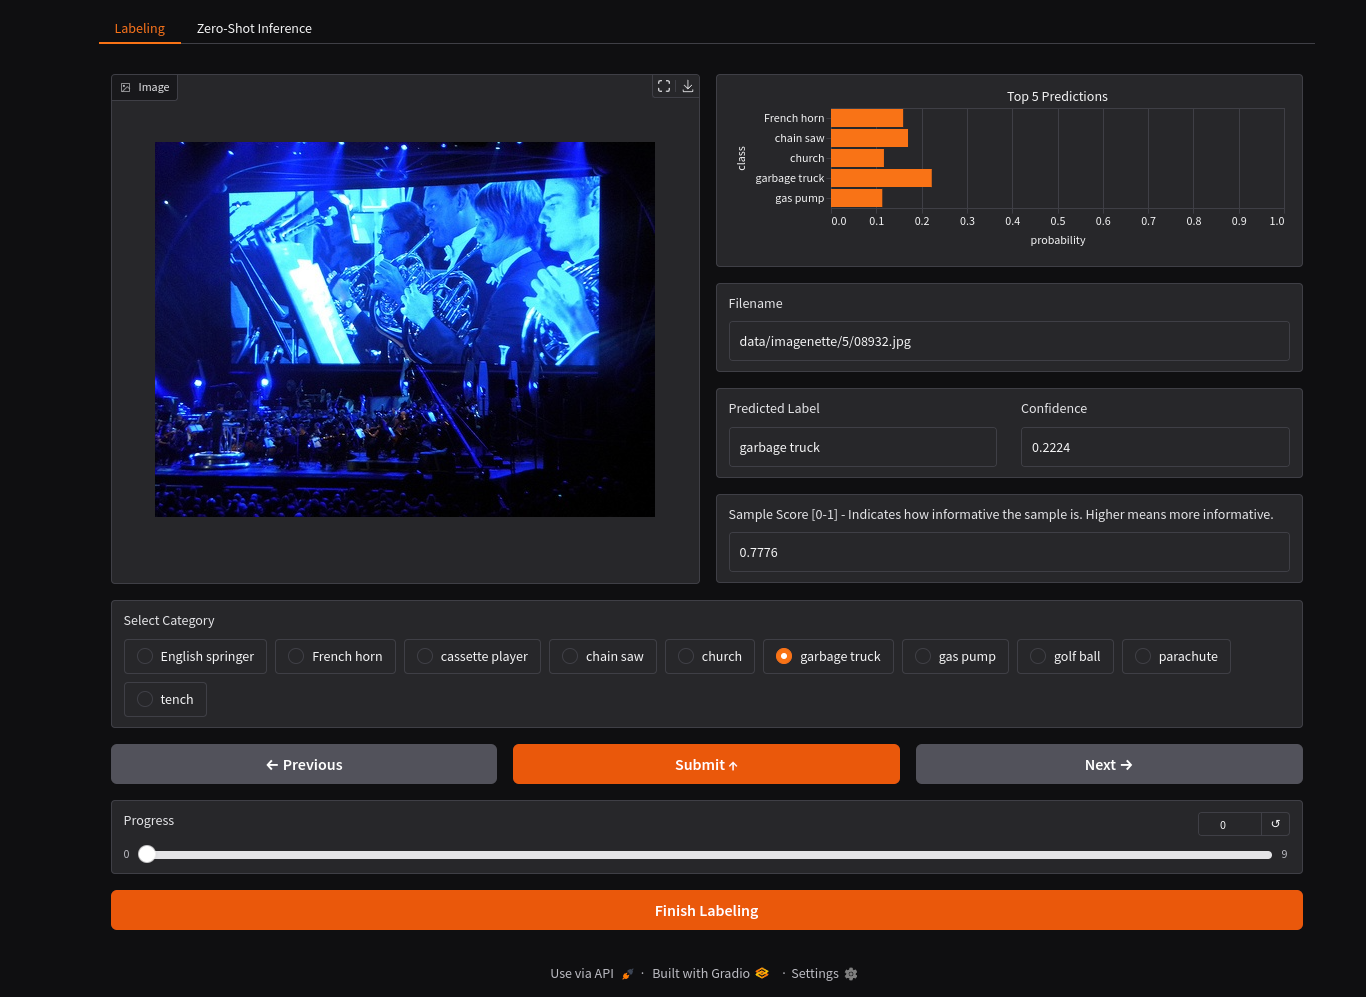

The Gradio interface will open up and you can label the samples. You could also see the confidence of the model for each sample to debug the model.

We can inspect the samples we just labeled.

In [26]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


,filepath,label
0,data/imagenette/train/n03425413/n03425413_14415.JPEG,gas pump
1,data/imagenette/train/n03445777/n03445777_894.JPEG,golf ball
2,data/imagenette/train/n03417042/n03417042_4587.JPEG,garbage truck
3,data/imagenette/train/n03888257/n03888257_949.JPEG,parachute
4,data/imagenette/train/n03425413/n03425413_21314.JPEG,gas pump
5,data/imagenette/train/n03417042/n03417042_1716.JPEG,garbage truck
6,data/imagenette/train/n03417042/n03417042_7506.JPEG,garbage truck
7,data/imagenette/train/n03000684/n03000684_31035.JPEG,chain saw
8,data/imagenette/train/n03000684/n03000684_948.JPEG,chain saw
9,data/imagenette/train/n03000684/n03000684_15363.JPEG,chain saw


## Add to train set

Now that we have labeled the samples, we can add them to the train set and save it to a parquet file named `active_labeled.parquet`.

In [27]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")

2025-01-28 00:34:23.476 | INFO     | active_vision.core:add_to_train_set:841 - Adding 27 samples to training set
2025-01-28 00:34:23.481 | INFO     | active_vision.core:add_to_train_set:850 - Saved training set to active_labeled.parquet


## Repeat

We can repeat the process of predicting, sampling, labeling, and adding to the train set until we have a good model.